## Data Cleansing for Dashboard + ETL

In [195]:
# imports needed to run all processes
from get_all_tickers import get_tickers as gt
import  yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [17]:
# This process is used to download and get the name of all tickers needed 
# used the following we address to dowload the needed csv for manipulation
# https://www.nasdaq.com/market-activity/stocks/screener. I downloaded the Finance Tech and Energy Industries
nasdaq = pd.read_csv('nasdaq_screener.csv')
# change to list of tickers
tickers = [i for i in nasdaq['Symbol']]
# download first row of data
data = yf.download(tickers[0], start="2014-01-01", end="2020-01-01" ,group_by='Ticker')
# create row for ticker
data['ticker'] = tickers[0]
# for loop to append all other rows to initial one
for item in tickers[1:]:
    try:
        dat = yf.download(item, start="2014-01-01", end="2020-01-01" ,group_by='ticker')
    except ValueError:
        continue
    dat['ticker'] = item
    if dat.shape[0] == 0:
        continue
    data  = pd.concat([data, dat])
# write to csv
data.to_csv('nasdaq.csv') 

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AACQ: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AACQU: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AACQW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AAN: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[***

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AHAC: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AHACU: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AHACW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AI: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[****

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ASAN: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ASAQ: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ASPL: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BHSE: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BHSEU: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BHSEW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BIGC: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BSN: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BSY: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BTAQ: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BT

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CFAC: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CFACU: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CFACW: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CPSR: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CRC: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- DFPH: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- DFPHU: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- DFPHW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- DGNR: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[**

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ENVIU: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- EPHYU: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- EQD: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[********************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FGFPP: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FGNA: Data doesn't exist for startDate = 1388559600, endDate = 

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FTOCU: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FTOCW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FULTP: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FUSE: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- GRCYW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- GRSV: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- GRSVU: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- GRSVW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed do

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- HOL: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- HOLUU: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- HOLUW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*****

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- INKAU: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*****

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- KLAQU: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- KSMT: Data doesn't exist for startDate = 1388559600, 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- LSAQ: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- LSPD: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MLACU: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MLACW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- NGACU: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- NGACW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- NHIC: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- NHICU: D

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- OPENW: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- OPINL: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*********************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- PHUNW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- PIAI: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- PIPP: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*****

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- QELL: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- QELLU: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- QELLW: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*******************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- RXT: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SABRP: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SVOKU: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SVSVU: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SVSVW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SWETU: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- TPGY: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- TREB: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- VACQW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- VCKAU: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- VCVC: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- VCVCU: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed

1

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- WPF: Data doesn't exist for startDate = 1388559600, endDate = 1577862000
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*******

In [44]:
# class for downloading data
class download_data:
    # method to perform the download
    def Download():
        nasdaq = pd.read_csv('nasdaq_screener.csv')
        # change to list of tickers
        tickers = [i for i in nasdaq['Symbol']]
        # download first row of data
        data = yf.download(tickers[0], start="2018-01-01", end="2021-01-26" ,group_by='Ticker')
        # create row for ticker
        data['ticker'] = tickers[0]
        # for loop to append all other rows to initial one
        for item in tickers[1:]:
            try:
                dat = yf.download(item, start="2018-01-01", end="2021-01-26" ,group_by='ticker')
            except ValueError:
                continue
            dat['ticker'] = item
            if dat.shape[0] == 0:
                continue
            data  = pd.concat([data, dat])
        # write to csv
        data.to_csv('nasdaq.csv') 
        

download_data.Download()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AACQW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[***************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AMHCW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[***************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BCACU: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[***************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BROGW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- BRPAW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 complete

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CGNTV: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- CGROW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 complete

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- FCF: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*****************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- GBLIL: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- GCMGW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 complete

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- HCARW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- HCIIU: Data doesn't exist for startDate = 1514790000, endDate = 1611644400
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- INAQW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[***************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- KSMTW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[***************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- SVSVW: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[***************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- VRNTV: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[***************

In [196]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 19 14:46:53 2021

@author: akniels1
"""
import findspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc, stddev_samp, stddev_pop, lag, lead
from pyspark.sql.functions import asc, col,avg, last
from pyspark.sql.functions import sum as Fsum
import pandas as pd
from pyspark.sql.window import Window
import sys


## Initialize a class for the fin_dataet
class fin_data:
    def __init__(self, list_of_csv = ["nasdaq.csv"] ):
        self._list_of_csv = list_of_csv
    
## initialize spark
    def initspark(self):
        spark = SparkSession \
            .builder \
            .appName("Python Fin Data") \
            .config("local") \
            .getOrCreate()
        return spark
## Read data from csv to spark dataframes         
    def read_csv_to_spark(self, spark):
        list_of_spark =  []
        names_of_tables = []
        for item in self._list_of_csv:
            names_of_tables.append(str(item[:-4]))
            app =  spark.read.format("csv").option("header", "true").load(item)
            list_of_spark.append( app )
        return list_of_spark, names_of_tables
    
## union the data together
    
    def Spark_union(self,sprk_list, table_names, spark):
        spark_string = ''
        for i in range(len(sprk_list)):
            sprk_list[i].createOrReplaceTempView(table_names[i])
            if i == (len(sprk_list)-1):
                spark_string += 'Select * from '+ table_names[i]
            else:
                spark_string +='Select * from '+ table_names[i]+ ' Union All '
        
        union_all = spark.sql(spark_string)
        return union_all
 ## fron fill the data and remove any NAN values   
    def ffill_and_remove(self, sparktable):
        # define the window
        window = Window.partitionBy('ticker')\
                       .orderBy('Date')\
                       .rowsBetween(-sys.maxsize, 0)

        # define the forward-filled column
        clean_open = last(sparktable['Open'], ignorenulls=True).over(window)
        clean_high = last(sparktable['High'], ignorenulls=True).over(window)
        clean_low = last(sparktable['Low'], ignorenulls=True).over(window)
        clean_close = last(sparktable['Close'], ignorenulls=True).over(window)
        clean_adj_close = last(sparktable['Adj Close'], ignorenulls=True).over(window)
        clean_volume = last(sparktable['Volume'], ignorenulls=True).over(window)

        # do the fill
        spark_df_filled = sparktable.withColumn('Open', clean_open)
        spark_df_filled = spark_df_filled.withColumn('High', clean_high)
        spark_df_filled = spark_df_filled.withColumn('Low', clean_low)
        spark_df_filled = spark_df_filled.withColumn('Close', clean_close)
        spark_df_filled = spark_df_filled.withColumn('Adj Close', clean_adj_close)
        spark_df_filled = spark_df_filled.withColumn('Volume', clean_volume)

        #remove items that are blank (beforestock inception)
        spark_df_filled.na.drop('any')

        
        return spark_df_filled




        
    
    def add_additional_fields(self,table):
        days = lambda i: i * 86400

        
        windowSpec = Window.partitionBy("ticker").orderBy(col("Date").cast('long')).rowsBetween(-7, 0)
        
        windowSpec20 = Window.partitionBy("ticker").orderBy(col("Date").cast('long')).rowsBetween(-20, 0)
        
        date_spec = Window.partitionBy("ticker").orderBy("Date")
        
        
        
        
        
        union_table = table.withColumn('rolling_seven_day_average', avg("Close").over(windowSpec)) 
        
        union_table = union_table.withColumn('rolling_20_day_average', avg("Close").over(windowSpec20)) 
        
        union_table = union_table.withColumn('Prev Close', lag("Close").over(date_spec))
        
        union_table = union_table.withColumn('Lead 5 Close', lag(col("Close"), 5).over(date_spec))


        
        union_table = union_table.withColumn('DailyReturn',  (union_table['Close'] - union_table['Prev Close'])/ 
union_table['Close'] )


        
        union_table = union_table.withColumn('stdev', stddev_pop("Close").over(windowSpec20))
        
        union_table = union_table.withColumn('Upper', union_table['rolling_20_day_average'] + (union_table['stdev']*2) )
        
        union_table = union_table.withColumn('Lower', union_table['rolling_20_day_average'] - (union_table['stdev']*2) )
        
        return union_table
    
    def get_distinct_tickers(self, sparkframe):
         
        
        return [i.ticker for i in sparkframe.select('ticker').distinct().collect()]
        

fin = fin_data()    
spark = fin.initspark()   
list_spark , table_name = fin.read_csv_to_spark(spark)
union_all = fin.Spark_union(list_spark, table_name,spark)
clean_data = fin.ffill_and_remove(union_all)
final_dataset = fin.add_additional_fields(clean_data)
distinct_tickers = fin.get_distinct_tickers(final_dataset)

In [197]:

## Example of how to dowload stock data from the internet
distinct_tickers
    

['BAND',
 'BOX',
 'BROG',
 'CARS',
 'HBNC',
 'KLR',
 'LATN',
 'LMND',
 'PROS',
 'SPGI',
 'AEFC',
 'BCOV',
 'BHFAL',
 'BYFC',
 'ENSV',
 'HUBS',
 'IGC',
 'PTICU',
 'SABR',
 'SDPI',
 'SMTX',
 'SOGO',
 'KKR',
 'RBKB',
 'RF',
 'RMBS',
 'RNDB',
 'SABRP',
 'SBT',
 'WABC',
 'ARL',
 'AXP',
 'BEKE',
 'GDP',
 'GEG',
 'NGS',
 'PNFP',
 'API',
 'BUR',
 'CAPL',
 'CSOD',
 'ESGRO',
 'ESGRP',
 'FI',
 'INFO',
 'JKS',
 'LFTRU',
 'PFG',
 'PTK',
 'SC',
 'AVNW',
 'BLK',
 'BUSE',
 'CRWD',
 'EA',
 'GFNCP',
 'MIC',
 'OXY',
 'PKBK',
 'ROOT',
 'AHAC',
 'BREZ',
 'EIG',
 'FHB',
 'MTCH',
 'NGL',
 'NS',
 'PSACU',
 'SNX',
 'TBA',
 'UBS',
 'CACC',
 'CSIQ',
 'FRAF',
 'GDRX',
 'KINZU',
 'OTRAU',
 'QADB',
 'SOS',
 'TPIC',
 'WDR',
 'ZM',
 'BTRS',
 'CASA',
 'HHR',
 'IBKR',
 'IGIC',
 'INBK',
 'LIVK',
 'OKTA',
 'OPINI',
 'PMBC',
 'PSTG',
 'TROW',
 'AEB',
 'ASYS',
 'CIH',
 'CMCM',
 'ERESU',
 'MPB',
 'NES',
 'PIPP',
 'TCF',
 'ACND',
 'BKI',
 'CRESY',
 'EMKR',
 'GHVIU',
 'MN',
 'PLTK',
 'SLCT',
 'SNPR',
 'SUPV',
 'TSM',
 'UNMA',

In [202]:
display(final_dataset)

DataFrame[Date: string, Open: string, High: string, Low: string, Close: string, Adj Close: string, Volume: string, ticker: string, rolling_seven_day_average: double, rolling_20_day_average: double, Prev Close: string, Lead 5 Close: string, DailyReturn: double, stdev: double, Upper: double, Lower: double]

In [203]:
final_dataset.createOrReplaceTempView('stocks')


In [204]:
PFG = spark.sql("Select * from stocks where ticker = 'PFG' and date >= '2020-12-01'")
PFG = PFG.toPandas()
PFG

,Date,Open,High,Low,Close,Adj Close,Volume,ticker,rolling_seven_day_average,rolling_20_day_average,Prev Close,Lead 5 Close,DailyReturn,stdev,Upper,Lower
0,2020-12-01,50.029998779296875,50.150001525878906,49.06999969482422,49.619998931884766,49.619998931884766,2550900.0,PFG,50.497500,47.105238,49.790000915527344,50.63999938964844,-0.003426,3.686012,54.477262,39.733214
1,2020-12-02,49.290000915527344,51.09000015258789,49.08000183105469,50.86000061035156,50.86000061035156,1398000.0,PFG,50.738750,47.636191,49.619998931884766,52.599998474121094,0.024381,3.372218,54.380626,40.891755
2,2020-12-03,50.540000915527344,51.84000015258789,50.540000915527344,51.36000061035156,51.36000061035156,1374900.0,PFG,51.033750,48.091429,50.86000061035156,52.0,0.009735,3.194210,54.479848,41.703009
3,2020-12-04,51.91999816894531,52.70000076293945,51.849998474121094,52.279998779296875,52.279998779296875,1111400.0,PFG,51.238750,48.594286,51.36000061035156,51.400001525878906,0.017598,2.975306,54.544897,42.643674
4,2020-12-07,51.650001525878906,51.70000076293945,50.34000015258789,50.709999084472656,50.709999084472656,1377600.0,PFG,51.002500,48.960952,52.279998779296875,49.790000915527344,-0.030960,2.728771,54.418494,43.503411
5,2020-12-08,50.040000915527344,51.06999969482422,50.040000915527344,50.77000045776367,50.77000045776367,1444800.0,PFG,50.848750,49.408572,50.709999084472656,49.619998931884766,0.001182,2.158179,53.724929,45.092214
6,2020-12-09,51.189998626708984,51.369998931884766,50.0099983215332,50.04999923706055,50.04999923706055,1764600.0,PFG,50.680000,49.523333,50.77000045776367,50.86000061035156,-0.014386,2.124903,53.773139,45.273528
7,2020-12-10,49.119998931884766,50.06999969482422,49.0,49.81999969482422,49.81999969482422,1848500.0,PFG,50.683750,49.646190,50.04999923706055,51.36000061035156,-0.004617,2.063018,53.772226,45.520155
8,2020-12-11,48.7599983215332,49.529998779296875,48.369998931884766,48.77000045776367,48.77000045776367,1485100.0,PFG,50.577500,49.799524,49.81999969482422,52.279998779296875,-0.021530,1.862820,53.525164,46.073883
9,2020-12-14,49.689998626708984,49.97999954223633,47.599998474121094,47.81999969482422,47.81999969482422,2074700.0,PFG,50.197500,49.953333,48.77000045776367,50.709999084472656,-0.019866,1.529934,53.013201,46.893465


In [205]:
%matplotlib inline
#PFG.plot()

#plt.figure(figsize=(10,10))
fig = go.Figure()
fig.add_trace(go.Scatter(x=PFG.Date, y=PFG.Close,
                    mode='lines',
                    name='Close'))
fig.add_trace(go.Scatter(x=PFG.Date, y=PFG.rolling_20_day_average,
                    mode='lines',
                    name='20 Day Rollling Average'))
# plt.xlabel("date")
# plt.ylabel("$ price")
# plt.title("PFG Stock Price 12/1/20 - 1/1/21")

In [206]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=PFG.Date, y=PFG.Close,
                    mode='lines',
                    name='Close'))
fig.add_trace(go.Scatter(x=PFG.Date, y=PFG.Upper,
                    mode='lines',
                    name='Upper Bollinger™'))
fig.add_trace(go.Scatter(x=PFG.Date, y=PFG.Lower,
                    mode='lines',
                    name='Lower Bollinger™'))

In [207]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=PFG.Date, y=PFG.DailyReturn,
                    mode='lines',
                    name='DailyReturn'))

In [208]:
AIG = spark.sql("Select * from stocks where ticker = 'AIG' and date >= '2020-12-01'")
AIG = AIG.toPandas()
AIG

,Date,Open,High,Low,Close,Adj Close,Volume,ticker,rolling_seven_day_average,rolling_20_day_average,Prev Close,Lead 5 Close,DailyReturn,stdev,Upper,Lower
0,2020-12-01,39.5,39.779998779296875,39.09000015258789,39.310001373291016,38.99322509765625,6245700.0,AIG,39.435000,37.187619,38.439998626708984,39.77000045776367,0.022132,2.726501,42.640621,31.734617
1,2020-12-02,39.060001373291016,39.88999938964844,38.7599983215332,39.72999954223633,39.40983963012695,5175400.0,AIG,39.583750,37.534286,39.310001373291016,40.97999954223633,0.010571,2.559808,42.653901,32.414671
2,2020-12-03,39.66999816894531,40.27000045776367,39.52000045776367,39.84000015258789,39.518951416015625,4581300.0,AIG,39.737500,37.865238,39.72999954223633,40.119998931884766,0.002761,2.380993,42.627225,33.103251
3,2020-12-04,40.25,40.810001373291016,40.150001525878906,40.689998626708984,40.36210250854492,4597600.0,AIG,39.852499,38.298571,39.84000015258789,39.709999084472656,0.020890,1.996533,42.291638,34.305505
4,2020-12-07,40.279998779296875,40.34000015258789,39.56999969482422,39.790000915527344,39.469356536865234,4478500.0,AIG,39.703750,38.601428,40.689998626708984,38.439998626708984,-0.022619,1.694589,41.990606,35.212251
5,2020-12-08,39.279998779296875,39.95000076293945,39.18000030517578,39.52000045776367,39.20153045654297,3322600.0,AIG,39.628750,38.904286,39.790000915527344,39.310001373291016,-0.006832,1.187488,41.279263,36.529309
6,2020-12-09,39.90999984741211,40.290000915527344,39.560001373291016,39.939998626708984,39.61814498901367,5388400.0,AIG,39.657500,39.019524,39.52000045776367,39.72999954223633,0.010516,1.164766,41.349056,36.689991
7,2020-12-10,39.279998779296875,39.939998626708984,39.060001373291016,39.709999084472656,39.38999938964844,4716300.0,AIG,39.816250,39.090000,39.939998626708984,39.84000015258789,-0.005792,1.159626,41.409252,36.770747
8,2020-12-11,38.83000183105469,39.16999816894531,38.560001373291016,38.790000915527344,38.790000915527344,5299000.0,AIG,39.751250,39.158571,39.709999084472656,40.689998626708984,-0.023717,1.095511,41.349594,36.967549
9,2020-12-14,39.29999923706055,39.369998931884766,38.08000183105469,38.15999984741211,38.15999984741211,3942000.0,AIG,39.555000,39.258571,38.790000915527344,39.790000915527344,-0.016509,0.883420,41.025411,37.491731


In [209]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=PFG.Date, y=PFG.DailyReturn,
                    mode='lines',
                    name='DailyReturn PFG'))
fig.add_trace(go.Scatter(x=AIG.Date, y=AIG.DailyReturn,
                    mode='lines',
                    name='DailyReturn AIG'))




## Machine Learning Section

In [210]:
# LSTM for Stock Market prediction
import numpy
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [211]:
## read in the finance data to get mored descriptive attributes

spark = SparkSession \
            .builder \
            .appName("Python Fin Data") \
            .config("local") \
            .getOrCreate()
app =  spark.read.format("csv").option("header", "true").load('nasdaq_screener.csv')


app.createOrReplaceTempView('nasdaq')

row_count = spark.sql("Select count(*) from stocks ")

row_count.toPandas().head()





,count(1)
0,1273652


In [212]:
app

DataFrame[Symbol: string, Name: string, Last Sale: string, Net Change: string, % Change: string, Market Cap: string, Country: string, IPO Year: string, Volume: string, Sector: string, Industry: string]

In [213]:
row_count_join = spark.sql("""
                            Select count(*) from

                            (Select *
                           from stocks s 
                           left join nasdaq n 
                           on s.Ticker = n.Symbol)
                           
                           """)
row_count.toPandas().head()

,count(1)
0,1273652


In [214]:
data_lake = spark.sql("""
                           

                            (Select stocks.* ,nasdaq.Sector, nasdaq.Industry
                           from stocks
                           left join nasdaq 
                           on Ticker = Symbol)
                           
                           """)
data_lake.limit(10).toPandas().head()

,Date,Open,High,Low,Close,Adj Close,Volume,ticker,rolling_seven_day_average,rolling_20_day_average,Prev Close,Lead 5 Close,DailyReturn,stdev,Upper,Lower,Sector,Industry
0,2018-01-02,23.329999923706055,24.399999618530273,23.0,23.239999771118164,23.239999771118164,111100.0,BAND,23.240000,23.240000,None,None,NaN,0.000000,23.240000,23.240000,Technology,Computer Software: Prepackaged Software
1,2018-01-03,23.059999465942383,23.709999084472656,23.024999618530273,23.530000686645508,23.530000686645508,78600.0,BAND,23.385000,23.385000,23.239999771118164,None,0.012325,0.145000,23.675001,23.094999,Technology,Computer Software: Prepackaged Software
2,2018-01-04,23.739999771118164,24.139999389648438,23.1299991607666,23.440000534057617,23.440000534057617,99100.0,BAND,23.403334,23.403334,23.530000686645508,None,-0.003840,0.121198,23.645730,23.160937,Technology,Computer Software: Prepackaged Software
3,2018-01-05,23.440000534057617,23.6200008392334,23.0,23.479999542236328,23.479999542236328,131000.0,BAND,23.422500,23.422500,23.440000534057617,None,0.001704,0.110085,23.642671,23.202329,Technology,Computer Software: Prepackaged Software
4,2018-01-08,23.65999984741211,23.90999984741211,23.094999313354492,23.5,23.5,59100.0,BAND,23.438000,23.438000,23.479999542236328,None,0.000851,0.103228,23.644456,23.231544,Technology,Computer Software: Prepackaged Software


In [215]:
from pyspark.ml.feature import StringIndexer

stringindex = StringIndexer(inputCols=["ticker","Sector", "Industry"], outputCols=["ticker_vector","Sector_vector", "Industry_Vector"])
model = stringindex.fit(data_lake)
encoded = model.transform(data_lake)
clean_data_lake = encoded.drop('Industry', 'Sector', 'ticker')
clean_data_lake = clean_data_lake.filter(clean_data_lake.DailyReturn. isNotNull())
clean_data_lake = clean_data_lake.select(*(col(c).cast("float").alias(c) for c in clean_data_lake.columns))
df = clean_data_lake.toPandas()
df.dtypes

Date                         float32
Open                         float32
High                         float32
Low                          float32
Close                        float32
Adj Close                    float32
Volume                       float32
rolling_seven_day_average    float32
rolling_20_day_average       float32
Prev Close                   float32
Lead 5 Close                 float32
DailyReturn                  float32
stdev                        float32
Upper                        float32
Lower                        float32
ticker_vector                float32
Sector_vector                float32
Industry_Vector              float32
dtype: object

In [216]:
# from pyspark.ml.stat import Correlation
# from pyspark.conf import SparkConf

df.corr()

,Date,Open,High,Low,Close,Adj Close,Volume,rolling_seven_day_average,rolling_20_day_average,Prev Close,Lead 5 Close,DailyReturn,stdev,Upper,Lower,ticker_vector,Sector_vector,Industry_Vector
Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Open,NaN,1.000000,0.997005,0.998213,0.997671,0.997667,-0.000183,0.994384,0.982055,0.998107,0.985473,-0.001599,0.636811,0.948103,0.984760,-0.015845,0.016802,-0.008683
High,NaN,0.997005,1.000000,0.996019,0.997393,0.997392,-0.000182,0.991773,0.981089,0.995245,0.982184,-0.000869,0.650023,0.950462,0.978767,-0.015847,0.017146,-0.008744
Low,NaN,0.998213,0.996019,1.000000,0.998807,0.998792,-0.000121,0.993795,0.980536,0.997307,0.984978,-0.000980,0.625232,0.944117,0.987084,-0.016021,0.016421,-0.008723
Close,NaN,0.997671,0.997393,0.998807,1.000000,0.999991,-0.000118,0.993746,0.981196,0.996600,0.985109,-0.000522,0.633010,0.946502,0.985077,-0.015952,0.016715,-0.008753
Adj Close,NaN,0.997667,0.997392,0.998792,0.999991,1.000000,-0.000116,0.993743,0.981203,0.996593,0.985110,-0.000533,0.633104,0.946530,0.985051,-0.015627,0.016915,-0.008959
Volume,NaN,-0.000183,-0.000182,-0.000121,-0.000118,-0.000116,1.000000,-0.000247,-0.000453,-0.000160,-0.000191,0.009325,-0.001040,-0.000615,-0.000184,-0.045184,0.103197,0.055271
rolling_seven_day_average,NaN,0.994384,0.991773,0.993795,0.993746,0.993743,-0.000247,1.000000,0.992950,0.995786,0.996966,-0.002178,0.669804,0.964789,0.986271,-0.015976,0.017025,-0.008698
rolling_20_day_average,NaN,0.982055,0.981089,0.980536,0.981196,0.981203,-0.000453,0.992950,1.000000,0.984287,0.991758,-0.002411,0.739552,0.987099,0.969676,-0.016022,0.017584,-0.008620
Prev Close,NaN,0.998107,0.995245,0.997307,0.996600,0.996593,-0.000160,0.995786,0.984287,1.000000,0.987406,-0.003760,0.641638,0.951062,0.985771,-0.015950,0.016790,-0.008732


In [242]:
## LSTM Model
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline

pfg_data = spark.sql("""
                            (Select stocks.* ,nasdaq.Sector, nasdaq.Industry
                           from stocks
                           left join nasdaq 
                           on Ticker = Symbol
                           where stocks.Ticker = 'PFG')
                           """)
pfg_data.dtypes
stringindex = StringIndexer(inputCols=["ticker","Sector", "Industry"], outputCols=["ticker_vector","Sector_vector", "Industry_Vector"])
model = stringindex.fit(pfg_data)
encoded = model.transform(pfg_data)
clean_data_lake = clean_data_lake.filter(clean_data_lake.DailyReturn. isNotNull())
clean_data_lake = clean_data_lake.select(*(col(c).cast("float").alias(c) for c in clean_data_lake.columns))
#scaler_ticker = MinMaxScaler(inputCol=["ticker_vector","Sector_vector", "Industry_Vector","Open", "High", "Low", "Volume","rolling_20_day_average","Upper", "Lower"], outputCol=["ticker_vector","Sector_vector", "Industry_Vector","Open", "High", "Low", "Volume","rolling_20_day_average", "Upper", "Lower"])
columns_to_scale = ["ticker_vector","Sector_vector", "Industry_Vector","Open", "High", "Low", "Volume","rolling_20_day_average","Upper", "Lower"]
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]
pipeline = Pipeline(stages=assemblers + scalers)
scalerModel = pipeline.fit(clean_data_lake)
scaledData = scalerModel.transform(clean_data_lake)

# model = pipeline.fit(encoded)
# encoded = model.transform(encoded)


# scaler = MinMaxScaler(inputCol=["ticker_vector","Sector_vector", "Industry_Vector","Open", "High", "Low", "Volume","rolling_20_day_average","Upper", "Lower"], outputCol=["ticker_vector","Sector_vector", "Industry_Vector","Open", "High", "Low", "Volume","rolling_20_day_average", "Upper", "Lower"])



# clean_data_lake = encoded.drop('Industry', 'Sector', 'ticker', 'Close')
# clean_data_lake = clean_data_lake.filter(clean_data_lake.DailyReturn. isNotNull())
# clean_data_lake = clean_data_lake.select(*(col(c).cast("float").alias(c) for c in clean_data_lake.columns))
# clean_data_lake.limit(10).toPandas().head()



In [244]:
# switching back to pandas because it has LSTM 
from sklearn.model_selection import TimeSeriesSplit
splits = TimeSeriesSplit(n_splits=3)


pfscaled = scaledData.toPandas()

,Date,Open,High,Low,Close,Adj Close,Volume,rolling_seven_day_average,rolling_20_day_average,Prev Close,...,ticker_vector_scaled,Sector_vector_scaled,Industry_Vector_scaled,Open_scaled,High_scaled,Low_scaled,Volume_scaled,rolling_20_day_average_scaled,Upper_scaled,Lower_scaled
0,NaN,23.059999,23.709999,23.025000,23.530001,23.530001,78600.0,23.385000,23.385000,23.240000,...,[0.05749770009199632],[0.5],[0.025],[0.0001966080290009592],[0.00018944003814675382],[0.00021033146354840215],[0.0001841246162899218],[0.0002214536071338354],[0.00020133385655156974],[0.026707099032131136]
1,NaN,23.740000,24.139999,23.129999,23.440001,23.440001,99100.0,23.403334,23.403334,23.530001,...,[0.05749770009199632],[0.5],[0.025],[0.00020241069926211494],[0.00019288004141376083],[0.0002112914595386764],[0.0002321469398769879],[0.00022162743530592538],[0.00020108452558179797],[0.026707778903716214]
2,NaN,23.440001,23.620001,23.000000,23.480000,23.480000,131000.0,23.422501,23.422501,23.440001,...,[0.05749770009199632],[0.5],[0.025],[0.00019985070533562596],[0.00018872005201204308],[0.00021010289556575867],[0.00030687436048320297],[0.00022180916640260993],[0.00020105848286696484],[0.02670820567451451]
3,NaN,23.660000,23.910000,23.094999,23.500000,23.500000,59100.0,23.438000,23.438000,23.480000,...,[0.05749770009199632],[0.5],[0.025],[0.00020172803312998156],[0.00019104004463427098],[0.00021097146087525165],[0.00013844484507295645],[0.00022195612101417913],[0.00020107368934299967],[0.0267085068978829]
4,NaN,23.680000,23.680000,23.270000,23.299999,23.299999,6200.0,23.415001,23.415001,23.500000,...,[0.05749770009199632],[0.5],[0.025],[0.00020189870373202602],[0.00018920004785478114],[0.0002125714716309947],[1.4523824694624875e-05],[0.00022173805816575417],[0.0002009480734533616],[0.026708184651613103]


In [304]:

pfg_data_final = spark.sql("""
                            (Select stocks.* ,nasdaq.Sector, nasdaq.Industry
                           from stocks
                           left join nasdaq 
                           on Ticker = Symbol
                           where stocks.Ticker = 'PFG')
                           """)
pfg_pandas = pfg_data_final.toPandas()
pfg_pandas = pfg_pandas.drop(['Sector', 'Industry', 'ticker'], axis = 1)
pfg_pandas   = pfg_pandas.dropna()
pfg_pandas = pfg_pandas.set_index('Date')
pfg_lead = pfg_pandas.pop('Lead 5 Close') # remove column b and store it in df1
pfg_pandas['Lead 5 Close']=pfg_lead # add b series as a 'new' column.

pfg_pandas.head(10)

,Open,High,Low,Close,Adj Close,Volume,rolling_seven_day_average,rolling_20_day_average,Prev Close,DailyReturn,stdev,Upper,Lower,Lead 5 Close
Date,,,,,,,,,,,,,,
2018-01-09,72.20999908447266,73.54000091552734,72.12000274658203,72.97000122070312,64.14071655273438,1477400.0,71.589999,71.589999,72.20999908447266,0.010415,0.918714,73.427427,69.752571,70.37999725341797
2018-01-10,73.0199966430664,74.05000305175781,72.79000091552734,73.37999725341797,64.50110626220703,1329600.0,71.845713,71.845713,72.97000122070312,0.005587,1.056313,73.958339,69.733087,70.52999877929688
2018-01-11,73.72000122070312,74.01000213623047,73.26000213623047,73.87999725341797,64.94061279296875,1147600.0,72.099998,72.099998,73.37999725341797,0.006768,1.195387,74.490773,69.709224,71.44999694824219
2018-01-12,74.08999633789062,74.4000015258789,73.61000061035156,74.20999908447266,65.23067474365234,1043200.0,72.578749,72.334443,73.87999725341797,0.004447,1.307628,74.949700,69.719186,72.0
2018-01-16,74.43000030517578,74.80000305175781,72.2699966430664,72.9000015258789,64.07919311523438,1440000.0,72.874999,72.390999,74.20999908447266,-0.017970,1.252074,74.895147,69.886850,72.20999908447266
2018-01-17,73.31999969482422,73.80000305175781,72.80000305175781,73.44999694824219,64.56263732910156,1015800.0,73.124999,72.487271,72.9000015258789,0.007488,1.232013,74.951298,70.023245,72.97000122070312
2018-01-18,73.58000183105469,73.94999694824219,73.3499984741211,73.4800033569336,64.58900451660156,924000.0,73.309999,72.569999,73.44999694824219,0.000408,1.211054,74.992106,70.147892,73.37999725341797
2018-01-19,73.77999877929688,74.29000091552734,73.4000015258789,74.05000305175781,65.09004211425781,1364700.0,73.540000,72.683846,73.4800033569336,0.007697,1.228562,75.140969,70.226722,73.87999725341797
2018-01-22,74.0999984741211,74.29000091552734,73.48999786376953,73.97000122070312,65.01972198486328,1008800.0,73.665000,72.775714,74.05000305175781,-0.001082,1.229337,75.234388,70.317040,74.20999908447266


In [320]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from math import sqrt

# normalize the dataset
values = pfg_pandas.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_pfg = scaler.fit_transform(values)
#dataset = scaler.fit_transform(pfg_pandas)

In [321]:

n_train_hours = int(len(pfg_pandas) * .9)
train = scaled_pfg[:n_train_hours, :]
test = scaled_pfg[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(689, 1, 13) (689,) (77, 1, 13) (77,)


Epoch 1/60
5/5 - 0s - loss: 0.5661 - val_loss: 0.3968
Epoch 2/60
5/5 - 0s - loss: 0.4734 - val_loss: 0.3163
Epoch 3/60
5/5 - 0s - loss: 0.3796 - val_loss: 0.2327
Epoch 4/60
5/5 - 0s - loss: 0.2829 - val_loss: 0.1442
Epoch 5/60
5/5 - 0s - loss: 0.1820 - val_loss: 0.0561
Epoch 6/60
5/5 - 0s - loss: 0.0873 - val_loss: 0.0489
Epoch 7/60
5/5 - 0s - loss: 0.0555 - val_loss: 0.0950
Epoch 8/60
5/5 - 0s - loss: 0.0693 - val_loss: 0.0704
Epoch 9/60
5/5 - 0s - loss: 0.0382 - val_loss: 0.0332
Epoch 10/60
5/5 - 0s - loss: 0.0439 - val_loss: 0.0284
Epoch 11/60
5/5 - 0s - loss: 0.0463 - val_loss: 0.0342
Epoch 12/60
5/5 - 0s - loss: 0.0366 - val_loss: 0.0477
Epoch 13/60
5/5 - 0s - loss: 0.0352 - val_loss: 0.0419
Epoch 14/60
5/5 - 0s - loss: 0.0304 - val_loss: 0.0318
Epoch 15/60
5/5 - 0s - loss: 0.0317 - val_loss: 0.0313
Epoch 16/60
5/5 - 0s - loss: 0.0301 - val_loss: 0.0348
Epoch 17/60
5/5 - 0s - loss: 0.0284 - val_loss: 0.0325
Epoch 18/60
5/5 - 0s - loss: 0.0272 - val_loss: 0.0292
Epoch 19/60
5/5 - 0

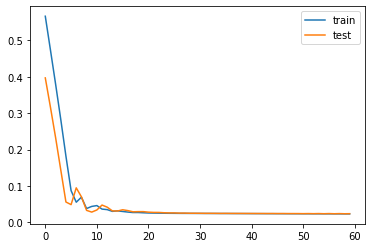

In [322]:
from matplotlib import pyplot
model = Sequential()
model.add(LSTM(60, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=60, batch_size=150, validation_data=(test_X, test_y), verbose=2, shuffle=False)
history

#plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [325]:

yhat = model.predict(test_X)
rmse = sqrt(mean_squared_error(yhat, test_y))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.030


array([0.31328613, 0.31250002, 0.31662736, 0.31839623, 0.33195753,
       0.34827046, 0.34532231, 0.37205188, 0.37912737, 0.35986637,
       0.36635218, 0.33588836, 0.33569185, 0.34198115, 0.33490567,
       0.32841979, 0.33529876, 0.33274371, 0.36910374, 0.38050315,
       0.35043242, 0.29854556, 0.2769261 , 0.29402513, 0.29599059,
       0.30562105, 0.34669809, 0.34512581, 0.37047952, 0.33824683,
       0.46147797, 0.45361638, 0.42040092, 0.40153302, 0.43514149,
       0.47484275, 0.48801103, 0.48801103, 0.48683176, 0.48820754,
       0.52044023, 0.55896223, 0.5471698 , 0.53537738, 0.50373429,
       0.50039305, 0.52476415, 0.5345912 , 0.55267292, 0.52181601,
       0.52299528, 0.50884432, 0.50432389, 0.48368711, 0.46501571,
       0.47523585, 0.47287738, 0.47641512, 0.46757076, 0.45872641,
       0.45676103, 0.47916668, 0.47798741, 0.48191824, 0.47621853,
       0.48388362, 0.50019655, 0.47464625, 0.48447329, 0.52948109,
       0.54205977, 0.54441824, 0.54323897, 0.55817612, 0.56092